# cat_dog 분류 실습

## 데이터셋 압축 풀기

In [93]:
import zipfile
import os
from sklearn.model_selection import train_test_split

In [ ]:
zip_file_path = '/content/drive/MyDrive/cat_dog.zip'

# 압축 해제할 폴더 경로
extracted_folder_path = '/content/drive/MyDrive/cat_dog_extracted'

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [94]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 생성기 설정
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 훈련 데이터셋 생성
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/cat_dog_extracted/PetImages',
    target_size=(224, 224),  # 이미지 크기 조절
    batch_size=32,
    class_mode='binary',  # 이진 분류인 경우 'binary'
    subset='training'  # 훈련 데이터 설정
)

# 테스트 데이터셋 생성
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/cat_dog_extracted/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 검증 데이터 설정
)

Found 20032 images belonging to 2 classes.
Found 5007 images belonging to 2 classes.


In [95]:
print(len(train_generator))
print(len(test_generator))

626
157


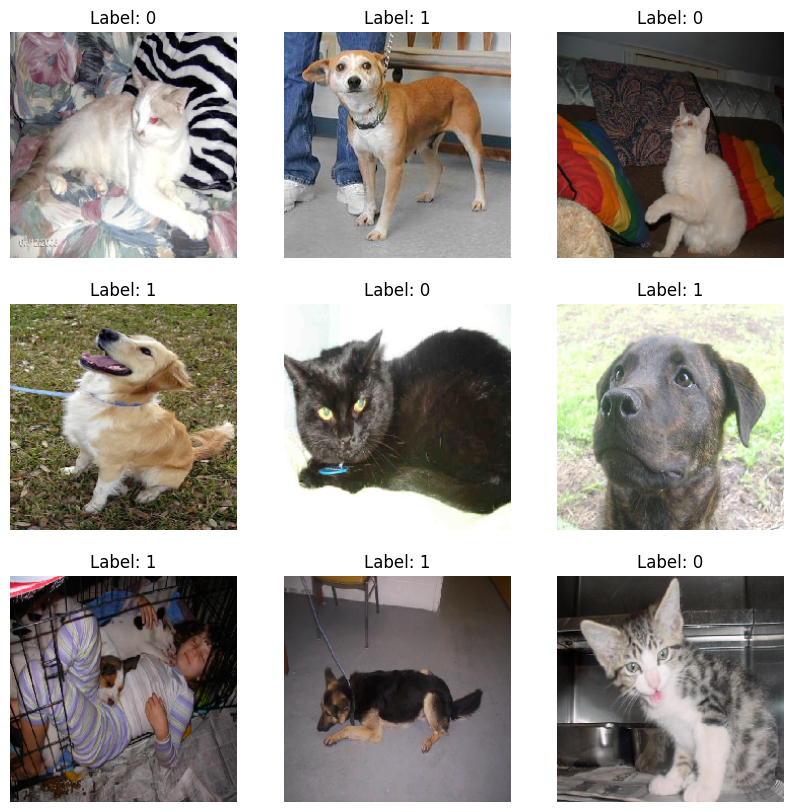

In [96]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

# 가져온 배치의 첫 번째 이미지와 라벨 시각화
plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))):  # 처음 9장의 이미지만 표시
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

plt.show()

## CNN 학습

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Sequential 모델 생성
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 2 클래스 이진 분류

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
  7/626 [..............................] - ETA: 56s - loss: 2.2011 - accuracy: 0.5402

KeyboardInterrupt: ignored

#

## test 예측

In [ ]:
predictions = model.predict(test_generator)

157/157 [==============================] - 20s 129ms/step
[[ 0.21026234]
 [99.99981   ]
 [99.96081   ]
 ...
 [81.77146   ]
 [ 9.726594  ]
 [34.112392  ]]


In [ ]:
actual_classes_binary = test_generator.classes

accuracy_binary = np.mean(np.equal(predictions, actual_classes_binary)) * 100

print(f'정확도: {accuracy_binary:.2f}%')

정확도: 0.97%


## 인퍼런스

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def inference(predictions, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    predicted_class = "Dog" if predictions[0][0] > 0.5 else "Cat"

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class}')
    plt.show()


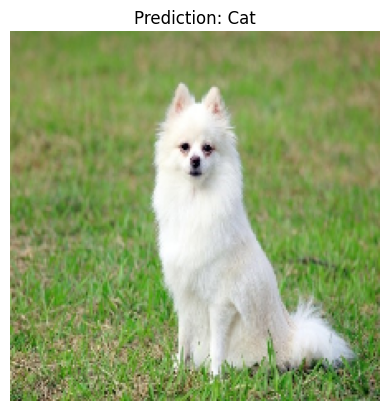

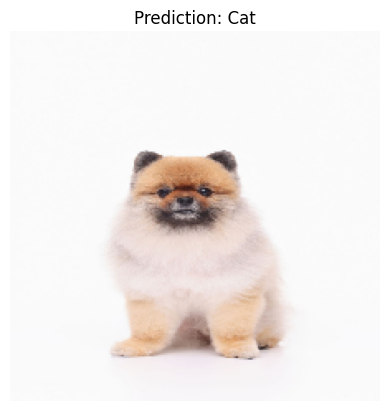

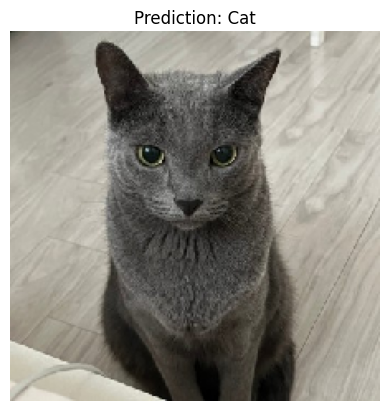

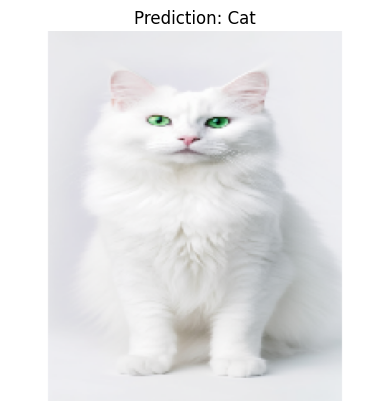

In [ ]:
inference(predictions, '/content/강아지1.jpg')
inference(predictions, '/content/강아지2.jpg')
inference(predictions, '/content/고양이1.jpg')
inference(predictions, '/content/고양이2.png')

# VGGNET 전이 학습

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기 (include_top=False로 설정하여 fully connected layers를 포함하지 않도록 설정)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # 2 클래스(고양이, 개) 이진 분류의 경우

# 기존 모델의 가중치를 동결하여 훈련하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 모델 훈련
history_vgg = model.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
625/625 [==============================] - 138s 218ms/step - loss: 0.2941 - accuracy: 0.8918 - val_loss: 0.1821 - val_accuracy: 0.9260
Epoch 2/5
625/625 [==============================] - 119s 190ms/step - loss: 0.1352 - accuracy: 0.9446 - val_loss: 0.1693 - val_accuracy: 0.9318
Epoch 3/5
625/625 [==============================] - 137s 219ms/step - loss: 0.1049 - accuracy: 0.9588 - val_loss: 0.1812 - val_accuracy: 0.9310
Epoch 4/5
625/625 [==============================] - 136s 217ms/step - loss: 0.0769 - accuracy: 0.9693 - val_loss: 0.2656 - val_accuracy: 0.9120
Epoch 5/5
625/625 [==============================] - 116s 185ms/step - loss: 0.0635 - accuracy: 0.9750 - val_loss: 0.2157 - val_accuracy: 0.9288


In [ ]:
predictions_vgg = model.predict(test_generator)

157/157 [==============================] - 25s 157ms/step


In [ ]:
actual_classes_binary = test_generator.classes

accuracy_binary = np.mean(1-(np.equal(predictions_vgg, actual_classes_binary))) * 100

print(f'vgg 정확도: {accuracy_binary:.2f}%')

vgg 정확도: 98.30%


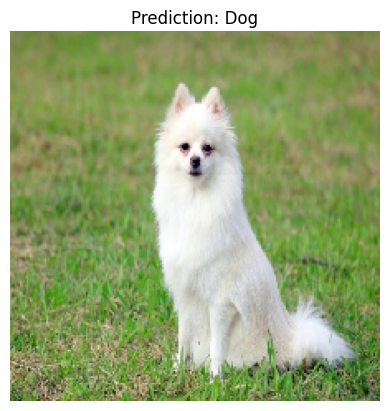

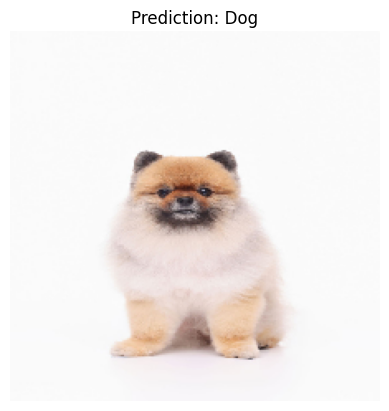

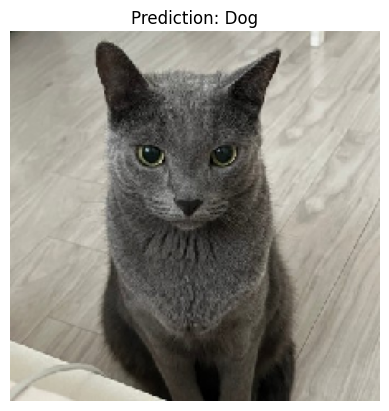

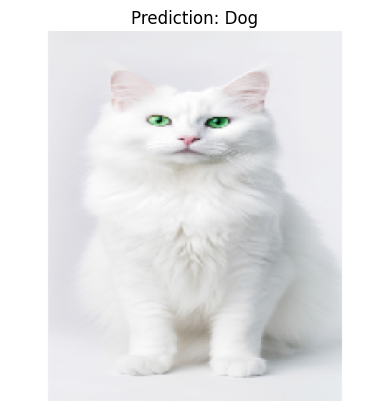

In [ ]:
inference(predictions_vgg, '/content/강아지1.jpg')
inference(predictions_vgg, '/content/강아지2.jpg')
inference(predictions_vgg, '/content/고양이1.jpg')
inference(predictions_vgg, '/content/고양이2.png')

## acc, loss 시각화

In [ ]:
def show_hists(history_vgg, history_cnn):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # VGG Model
    train_loss_vgg = history_vgg.history['loss']
    train_accuracy_vgg = history_vgg.history['accuracy']
    val_loss_vgg = history_vgg.history['val_loss']
    val_accuracy_vgg = history_vgg.history['val_accuracy']

    axes[0, 0].plot(range(1, len(train_loss_vgg) + 1), train_loss_vgg, label='Training Loss')
    axes[0, 0].plot(range(1, len(val_loss_vgg) + 1), val_loss_vgg, label='Validation Loss')
    axes[0, 0].set_title('VGG: Training and Validation Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[1, 0].plot(range(1, len(train_accuracy_vgg) + 1), train_accuracy_vgg, label='Training Accuracy')
    axes[1, 0].plot(range(1, len(val_accuracy_vgg) + 1), val_accuracy_vgg, label='Validation Accuracy')
    axes[1, 0].set_title('VGG: Training and Validation Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()

    # CNN Model
    train_loss_cnn = history_cnn.history['loss']
    train_accuracy_cnn = history_cnn.history['accuracy']
    val_loss_cnn = history_cnn.history['val_loss']
    val_accuracy_cnn = history_cnn.history['val_accuracy']

    axes[0, 1].plot(range(1, len(train_loss_cnn) + 1), train_loss_cnn, label='Training Loss')
    axes[0, 1].plot(range(1, len(val_loss_cnn) + 1), val_loss_cnn, label='Validation Loss')
    axes[0, 1].set_title('CNN: Training and Validation Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()

    axes[1, 1].plot(range(1, len(train_accuracy_cnn) + 1), train_accuracy_cnn, label='Training Accuracy')
    axes[1, 1].plot(range(1, len(val_accuracy_cnn) + 1), val_accuracy_cnn, label='Validation Accuracy')
    axes[1, 1].set_title('CNN: Training and Validation Accuracy')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

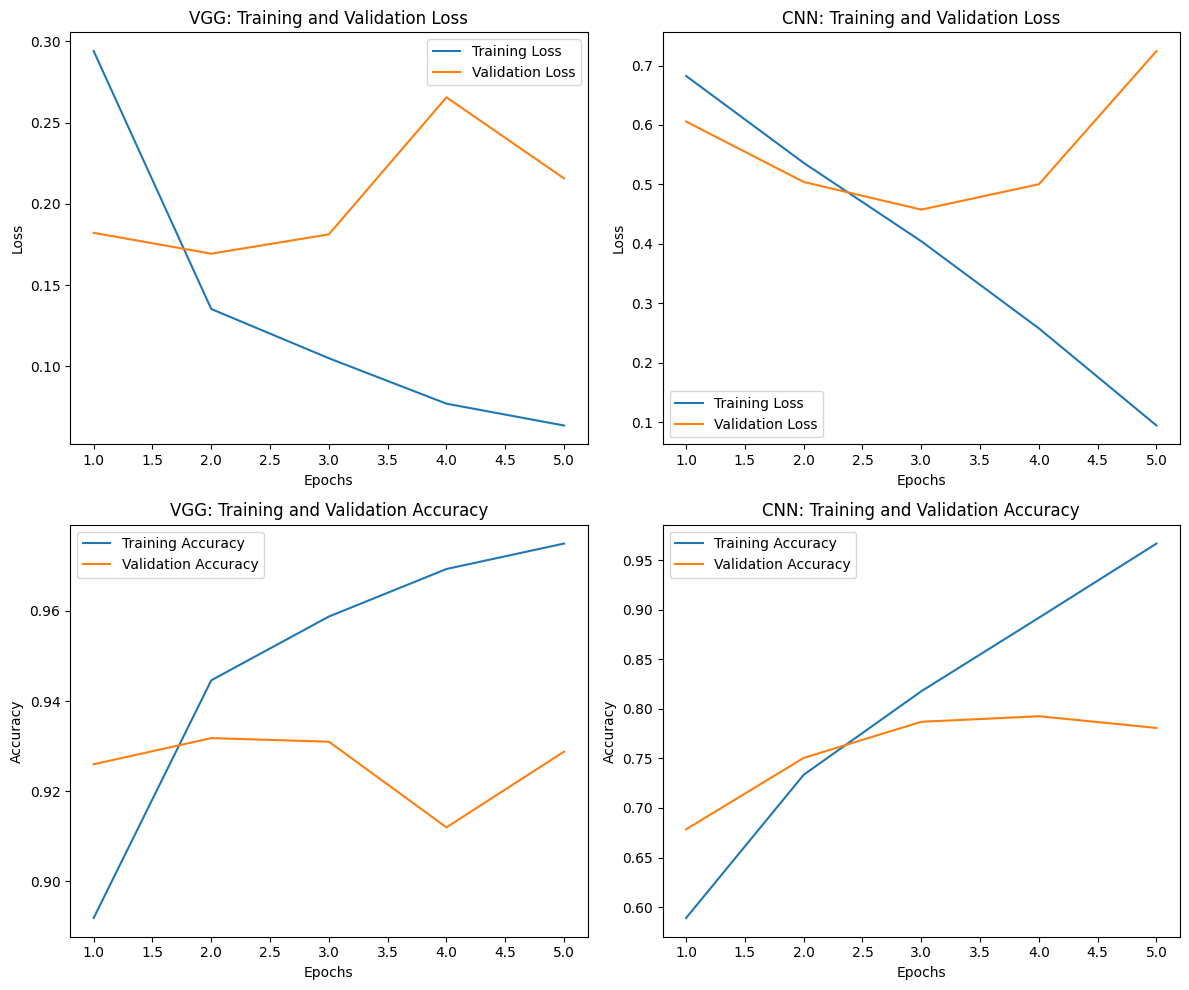

In [ ]:
show_hists(history_vgg, history_cnn)

In [ ]:
from tensorflow.keras.applications import ResNet50

# RESNET50 모델 가져오기 (include_top=False로 설정하여 fully connected layers를 포함하지 않도록 설정)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model3 = Sequential()

model3.add(base_model)

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))

model3.add(Dense(1, activation='sigmoid'))  # 2 클래스(고양이, 개) 이진 분류의 경우

# 기존 모델의 가중치를 동결하여 훈련하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 모델 훈련
history_res = model3.fit(train_generator, epochs=15, validation_data=test_generator)


Epoch 1/15
626/626 [==============================] - 113s 173ms/step - loss: 0.8201 - accuracy: 0.5404 - val_loss: 0.6596 - val_accuracy: 0.6399
Epoch 2/15
626/626 [==============================] - 102s 163ms/step - loss: 0.6405 - accuracy: 0.6432 - val_loss: 0.6373 - val_accuracy: 0.6467
Epoch 3/15
626/626 [==============================] - 100s 160ms/step - loss: 0.6087 - accuracy: 0.6773 - val_loss: 0.6038 - val_accuracy: 0.6786
Epoch 4/15
626/626 [==============================] - 99s 159ms/step - loss: 0.5819 - accuracy: 0.7002 - val_loss: 0.5697 - val_accuracy: 0.7144
Epoch 5/15
626/626 [==============================] - 99s 158ms/step - loss: 0.5624 - accuracy: 0.7145 - val_loss: 0.5525 - val_accuracy: 0.7282
Epoch 6/15
626/626 [==============================] - 99s 158ms/step - loss: 0.5467 - accuracy: 0.7257 - val_loss: 0.5433 - val_accuracy: 0.7322
Epoch 7/15
626/626 [==============================] - 100s 160ms/step - loss: 0.5361 - accuracy: 0.7335 - val_loss: 0.5534 - va

## 이미지 이상한거 확인

In [ ]:
from PIL import Image

dataset_path = '/content/drive/MyDrive/cat_dog_extracted/PetImages'
problematic_images = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        image_path = os.path.join(root, file)
        try:
            img = Image.open(image_path)
        except Exception as e:
            problematic_images.append(image_path)
            print(f"Error opening {image_path}: {e}")

print("Problematic Images:")
for img_path in problematic_images:
    print(img_path)

Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg'
Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/Thumbs.db: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/Thumbs.db'
Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/Thumbs.db: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/Thumbs.db'
Problematic Images:
/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg
/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/Thumbs.db
/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg
/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/Thumbs.db


In [ ]:
import os

# 삭제할 파일 경로들
file_paths_to_delete = [
    '/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg',
    '/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg'
]

# 파일 삭제
for file_path in file_paths_to_delete:
    try:
        os.remove(file_path)
        print(f"File deleted: {file_path}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error deleting file {file_path}: {e}")

File deleted: /content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg
File deleted: /content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg
